In [1]:
# Structure de données
import pandas as pd
import numpy as np
import pickle

# Traitement de texte
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk

# graphique
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from sklearn import manifold

# Réduction dimensionnelle
from sklearn.decomposition import NMF, PCA, LatentDirichletAllocation
from gensim.models import doc2vec
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline

# Modèles
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression

from sklearn import metrics
import time
import multiprocessing

# local
from custom_estimator import TfIdfCustomized

# A. Import de données

In [2]:
# train
train = pd.read_csv('clean_train.csv', sep=',', header=0)
# test
test = pd.read_csv('clean_test.csv', sep=',', header=0)

In [3]:
train.head()

,Labels,Label,Text,Tokens
0,mysql,mysql,data type use mysql database long pair best us...,"['data', 'type', 'use', 'mysql', 'database', '..."
1,xcode,xcode,find line number xcode editor xcode line numbe...,"['find', 'line', 'number', 'xcode', 'editor', ..."
2,android,android,android base string remote database string ima...,"['android', 'base', 'string', 'remote', 'datab..."
3,android,android,one use simple callback android working app tr...,"['one', 'use', 'simple', 'callback', 'android'..."
4,"ios, string, iphone",ios,figure size based string swift trying calculat...,"['figure', 'size', 'based', 'string', 'swift',..."


##### Lors de l'import les listes de string sont convertis, on doit donc reformater la colonne Tokens afin d'exploiter les tokens sans les '' qui les entourent

In [4]:
train['Clean_tokens'] = list([str(x).split(' ') for x in train['Text']])
test['Clean_tokens'] = list([str(x).split(' ') for x in test['Text']])

In [5]:
test.head()

,Labels,Label,Text,Tokens,Clean_tokens
0,"file, javascript",file,javascript create save file data want write fi...,"['javascript', 'create', 'save', 'file', 'data...","[javascript, create, save, file, data, want, w..."
1,eclipse,eclipse,folder eclipse search way certain folder searc...,"['folder', 'eclipse', 'search', 'way', 'certai...","[folder, eclipse, search, way, certain, folder..."
2,python,python,set maximum line length using window want chan...,"['set', 'maximum', 'line', 'length', 'using', ...","[set, maximum, line, length, using, window, wa..."
3,html,html,properly quote inside html attribute drop web ...,"['properly', 'quote', 'inside', 'html', 'attri...","[properly, quote, inside, html, attribute, dro..."
4,"pandas, python, dataframe",pandas,check column exists panda way check column exi...,"['check', 'column', 'exists', 'panda', 'way', ...","[check, column, exists, panda, way, check, col..."


In [6]:
print('Le jeu d\'entraîenemnt contient {} documents et {} variables'.format(
    train.shape[0], train.shape[1]))
print('Le jeu de test contient {} documents et {} variables'.format(
    test.shape[0], test.shape[1]))

Le jeu d'entraîenemnt contient 20805 documents et 5 variables
Le jeu de test contient 4991 documents et 5 variables


##### On récupère la liste des différents tags et on associe une couleur à chacun d'entre eux pour les visualisations qui vont suivre

In [7]:
tags_list = set(list(train['Label']))
colors = cm.rainbow(np.linspace(0, 1, len(tags_list)))


def color_from_tag(tag):
    return colors[list(tags_list).index(tag)]


colors_scatter = [color_from_tag(i) for i in train['Label']]

# B. Représentation du corpus

In [23]:
def plot_tsne(X_train, representation_name, n_plot_docs=5000):
    tsne = manifold.TSNE(n_components=2, perplexity=30, random_state=0)
    X_tsne = tsne.fit_transform(X_train)

    fig = plt.figure(figsize=(15, 10))
    plt.scatter(X_tsne[:n_plot_docs, 0], X_tsne[:n_plot_docs, 1],
                color=colors_scatter[:n_plot_docs])
    patches = [mpatches.Patch(color=color_from_tag(i), label=i)
               for i in tags_list]
    plt.legend(handles=patches, loc='upper center',
               ncol=7, bbox_to_anchor=(0.5, -0.05))
    plt.title("Projection TSNE d'une représentation {}\n avec une perplexité de 30".format(
        representation_name))

## B.1. Bag of Words (BOW)

##### Une première représentation du corpus peut être faite avec la matrice BOW, c'est une matrice documents / mots, avec les mots étant l'ensemble des mots du dictionnaire

In [24]:
count_vectorizer = CountVectorizer(min_df=5, analyzer='word')
X_train_cv = count_vectorizer.fit_transform(train.loc[:, 'Text'])
X_test_cv = count_vectorizer.transform(test.loc[:, 'Text'])
counter_feature_names = count_vectorizer.get_feature_names()

##### Cette représentation est intéressante mais peux exploitable en l'état car :
- la matrice est creuse
- les valeurs d'occurence ne prennent pas en compte la présence d'un mot par rapport à l'ensemble des documents

## B.2. Term Frequency - Inverse Document Frequency (TF-IDF)

##### Tentons alors une approche TF-IDF, similaire à la représentation précédente, cette matrice a l'avantage de prendre en compte la présence d'un mot par rapport aux autres documents.

In [25]:
dictionary_tfidf = [t for tokens in train['Clean_tokens'] for t in tokens]
# Ajout des tags au dictionnaire d'entrainement
dictionary_tfidf = set(dictionary_tfidf + list(tags_list))

In [26]:
# TF IDF
tfidf = TfidfVectorizer(vocabulary=np.array(list(dictionary_tfidf)))
train_tfidf = tfidf.fit_transform(train['Text'])
print('La matrice TF-IDF du jeu d\'entrainement représente {} documents par {} mots'.format(
    train_tfidf.shape[0], train_tfidf.shape[1]))
test_tfidf = tfidf.transform(test['Text'])
print('La matrice TF-IDF du jeu de test représente {} documents par {} mots'.format(
    test_tfidf.shape[0], test_tfidf.shape[1]))
tfidf_feature_names = tfidf.get_feature_names()

La matrice TF-IDF du jeu d'entrainement représente 20805 documents par 1200 mots
La matrice TF-IDF du jeu de test représente 4991 documents par 1200 mots


##### Comme précédemment, l'inconvénient de cette matrice est qu'elle est creuse.

In [27]:
# Transformation en matrice dense pour l'exploiter
X_train_tfidf = pd.DataFrame(
    train_tfidf.todense(), columns=tfidf_feature_names)
X_test_tfidf = pd.DataFrame(test_tfidf.todense(), columns=tfidf_feature_names)
X_train_tfidf.head()

,behaviour,mongodb,hash,ios,fails,big,html,re,new,account,...,speed,notification,together,bool,declaration,types,textview,post,developing,look
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.164287,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.110511
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


##### Afin de se faire une idée de la représentation on effectue une projection TSNE.

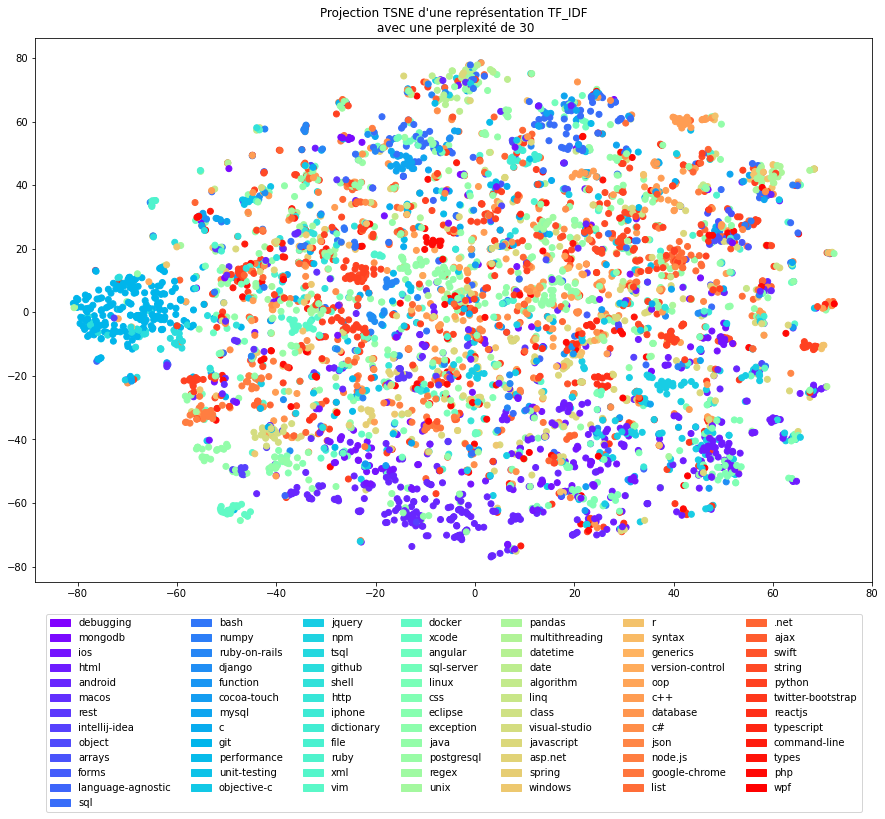

In [28]:
plot_tsne(X_train_tfidf, 'TF_IDF')
plt.savefig('tsne_tfidf.png', bbox_inches='tight')

##### Quelques clusters sont visibles sur cette projection (ex : git, java, ...) mais les clusters ne semblent pas bien délimités

## B.3. Plongement Doc2Vec

##### Une autre méthode de représentation est d'effectuer un plongement Doc2Vec qui permet de représenter chaque documents par un vecteur de mots dont la taille est définie. 

In [29]:
tagged_train_doc = [doc2vec.TaggedDocument(
    i, j) for i, j in zip(train['Clean_tokens'], train['Label'])]
d2v = doc2vec.Doc2Vec(tagged_train_doc, vector_size=100, window=10, min_count=2,
                      workers=multiprocessing.cpu_count(), alpha=0.025, min_alpha=0.010, epochs=20)

In [30]:
X_train_d2v = np.asmatrix(
    np.array([d2v.infer_vector(x) for x in train['Clean_tokens']]))
print('La matrice Doc2Vec du jeu d\'entrainement représente {} documents par {} mots'.format(
    X_train_d2v.shape[0], X_train_d2v.shape[1]))
X_test_d2v = np.asmatrix(
    np.array([d2v.infer_vector(x) for x in test['Clean_tokens']]))
print('La matrice Doc2Vec du jeu de test représente {} documents par {} mots'.format(
    X_test_d2v.shape[0], X_test_d2v.shape[1]))

La matrice Doc2Vec du jeu d'entrainement représente 20805 documents par 100 mots
La matrice Doc2Vec du jeu de test représente 4991 documents par 100 mots


##### Visualisons la projection TSNE après représentation Doc2Vec

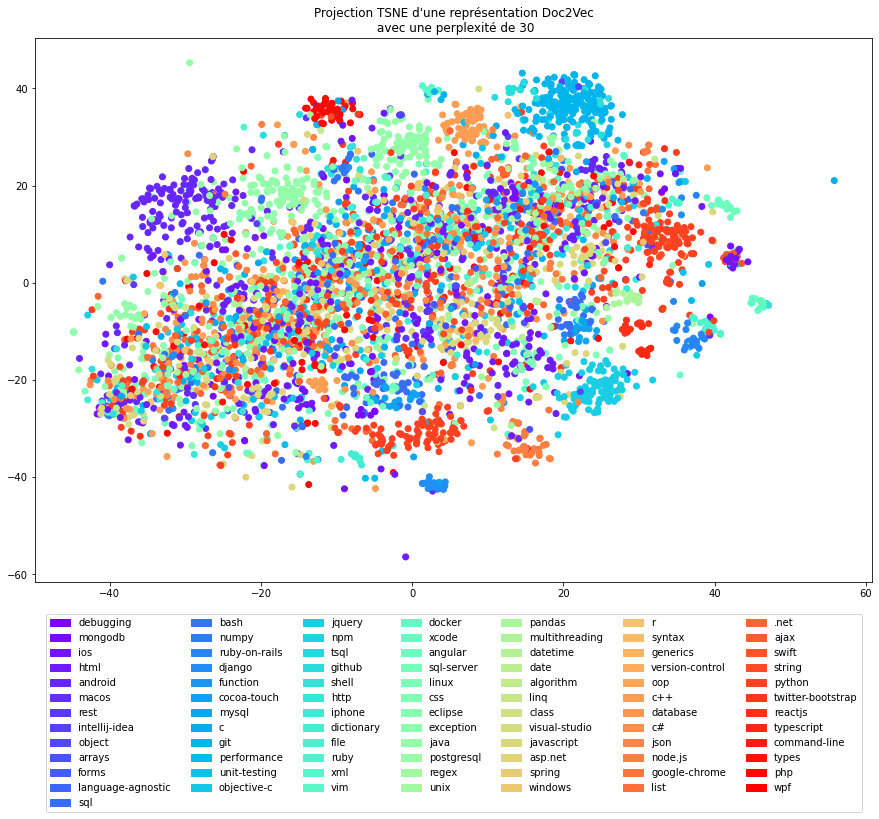

In [31]:
plot_tsne(X_train_d2v, "Doc2Vec")
plt.savefig('tsne_doc2vec.png', bbox_inches='tight')

##### Les clusters sont mieux définis que pour la matrice TF-IDF. Même si une partie des documents semblent éparses. Cette visualisation nous laisse penser que la méthode Doc2Vec est plus prometteuse. On la sélectionne donc pour l'étudier.

# C. Réduction dimensionnelle

##### Les matrices de représentation étant de taille conséquente. On effectue une réduction dimensionnelles sur celles-ci

## C.1. TF-IDF + PCA

##### On applique une analyse par composantes principales à notre matrice TF-IDF

In [32]:
# Calcul des composantes principales
pca = PCA(n_components=X_train_tfidf.shape[1])
pca = pca.fit(X_train_tfidf)

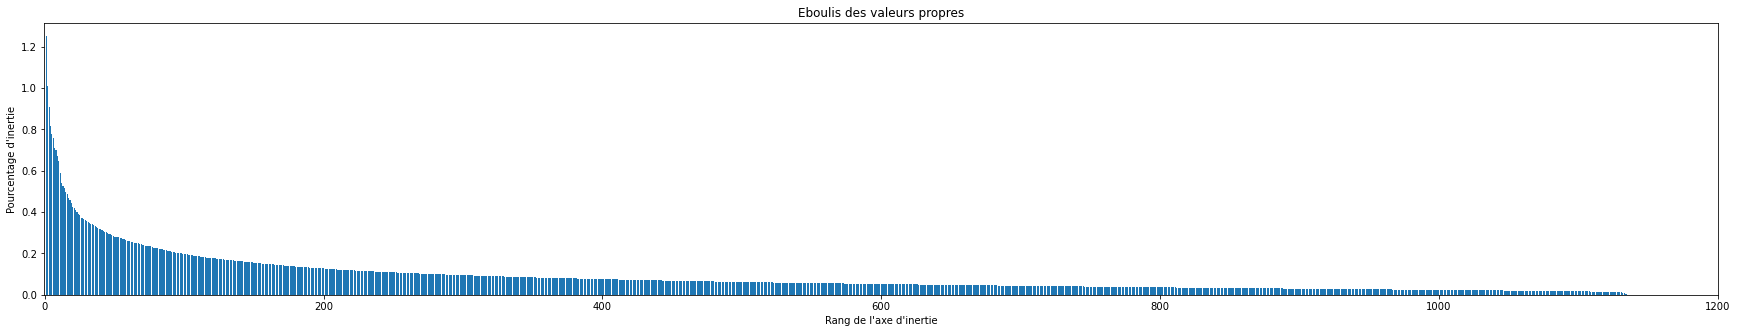

In [33]:
# Eboulis des valeurs propres
scree = pca.explained_variance_ratio_*100
plt.figure(figsize=(30, 5))
plt.bar(np.arange(len(scree))+1, scree)
plt.xlabel("Rang de l'axe d'inertie")
plt.xlim(-0.5, len(scree)+0.5)
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.savefig('eboulis_tfidf_pca.png', bbox_inches='tight')
plt.show(block=False)

##### On recherche le coude pour sélectionner les composantes principales à utiliser dans nos modèles

In [34]:
n_pca_tfidf = len(scree[scree > 0.4])
print("{} composantes principales sont sélectionnées pour nos modèles".format(n_pca_tfidf))

23 composantes principales sont sélectionnées pour nos modèles


In [35]:
pca = PCA(n_components=n_pca_tfidf)
X_train_tfidf_pca = pca.fit_transform(X_train_tfidf)
print('La matrice TF-IDF après application d\'une ACP du jeu d\'entrainement représente {} documents par {} composantes principales'.format(
    X_train_tfidf_pca.shape[0], X_train_tfidf_pca.shape[1]))
X_test_tfidf_pca = pca.transform(X_test_tfidf)
print('La matrice TF-IDF après application d\'une ACP du jeu de test représente {} documents par {} composantes principales'.format(
    X_test_tfidf_pca.shape[0], X_test_tfidf_pca.shape[1]))

La matrice TF-IDF après application d'une ACP du jeu d'entrainement représente 20805 documents par 23 composantes principales
La matrice TF-IDF après application d'une ACP du jeu de test représente 4991 documents par 23 composantes principales


##### On visualise encore une fois la projection TSNE

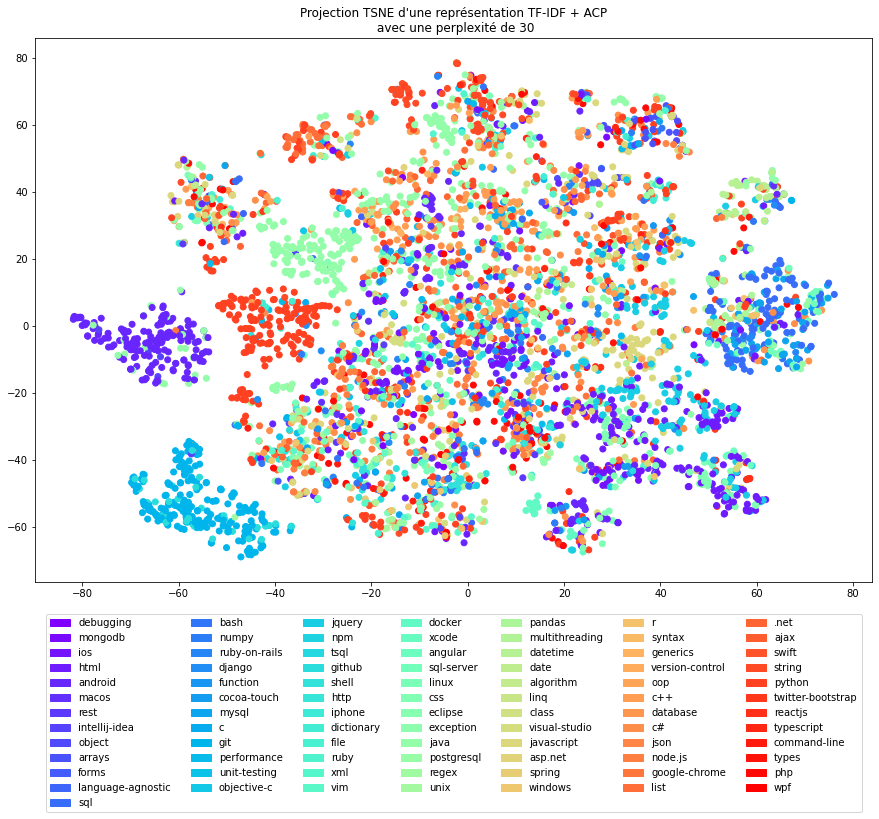

In [36]:
plot_tsne(X_train_tfidf_pca, 'TF-IDF + ACP')
plt.savefig('tsne_tfidf_pca.png', bbox_inches='tight')

##### Les clusters sont mieux séparés que pour la matrice TF-IDF seule. Cette représentation est donc sélectionnée pour être étudiée par la suite.

## C.2. Bag of Words + Latent Dirichlet Allocation (LDA)

##### Des méthodes de représentation non supervisée existent aussi. Celles-ci permettent d'extraire des topics indépendemment des labels et par le même temps de réduire la dimensionnalité.

In [37]:
def display_topics(model, feature_names, n_top_words):
    for i, topic in enumerate(model.components_):
        print("Topic {}".format(i))
        print(" ".join([feature_names[j]
                        for j in topic.argsort()[:-n_top_words - 1: -1]]))

##### On recherche le meilleur de nombre de sujets à exploiter pour une représentation LDA. Pour cela on cherche a minimiser la probabilité logarithmique (maximiser la probabilité logarithmique négative)

In [38]:
scores = []
topics = range(21, 30, 1)
for n in topics:
    lda = LatentDirichletAllocation(n_components=n,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0)
    lda.fit(X_train_cv)
    scores.append(lda.score(X_train_cv))

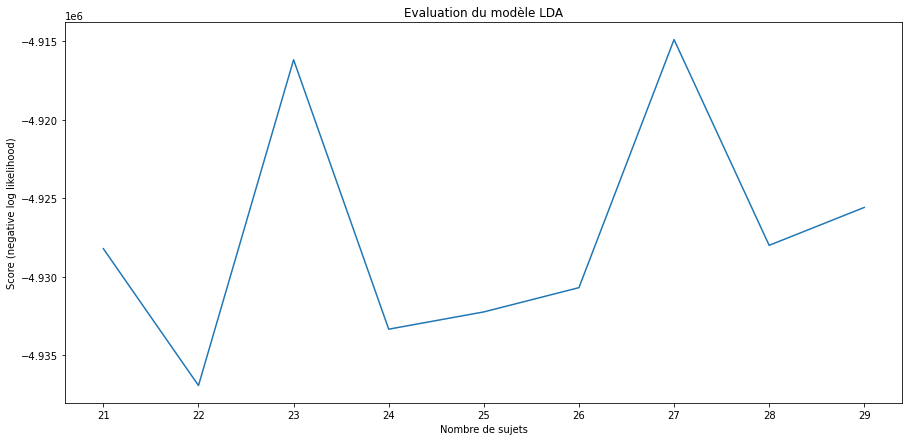

In [39]:
plt.figure(figsize=(15, 7))
plt.xlabel('Nombre de sujets')
plt.ylabel('Score (negative log likelihood)')
plt.plot(topics, scores)
plt.title('Evaluation du modèle LDA')
plt.savefig('score_lda_topics.png', bbox_inches='tight')

In [40]:
n_topics = scores.index(max(scores))+topics[0]
print("Le nombre de sujets optimal est {}".format(n_topics))
lda = LatentDirichletAllocation(n_components=n_topics,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

X_train_lda = lda.fit_transform(X_train_cv)
print('La matrice LDA du jeu d\'entrainement représente {} documents par {} sujets'.format(
    X_train_lda.shape[0], X_train_lda.shape[1]))
X_test_lda = lda.transform(X_test_cv)
print('La matrice LDA du jeu de test représente {} documents par {} sujets'.format(
    X_test_lda.shape[0], X_test_lda.shape[1]))

Le nombre de sujets optimal est 27
La matrice LDA du jeu d'entrainement représente 20805 documents par 27 sujets
La matrice LDA du jeu de test représente 4991 documents par 27 sujets


##### Regardons les 10 mots les plus représentatifs de chaque sujet pour essayer d'en extraire des sujets explicites

In [41]:
# Affichage des thèmes
n_top_word = 10
display_topics(lda, counter_feature_names, n_top_word)

Topic 0
name property id td person tr detect spring cell checkbox
Topic 1
array way like tag find something would search end ruby
Topic 2
table column select database sql query row mysql id value
Topic 3
script php bash echo hello shell replace space disable execute
Topic 4
use would like question one know way code example using
Topic 5
set change want check remove way field user need one
Topic 6
error app window application run message running get problem failed
Topic 7
div text input html class jquery element button event id
Topic 8
size px width style color height cs background screen top
Topic 9
class method variable difference attribute def use self interface call
Topic 10
android xml layoutheight layoutwidth merge id wrapcontent textview text button
Topic 11
git branch commit repository remote local master push change github
Topic 12
http url request user page get post server using web
Topic 13
function value var return javascript parameter code get console log
Topic 14
line opti

##### Le sujet 2 semble être relatif aux base de données
##### Le sujet 3 semble être relatif aux fenêtres de commande
##### Le sujet 7 semble être relatif au html

##### Même si on arrive à interpréter plusieurs sujets, il est difficile de faire ça pour chacun d'entre eux. Cela demande de l'expertise du domaine et de la créativité. On va donc plutôt essayer de faire le lien entre les sujets et les tags que l'on a déjà à notre disposition

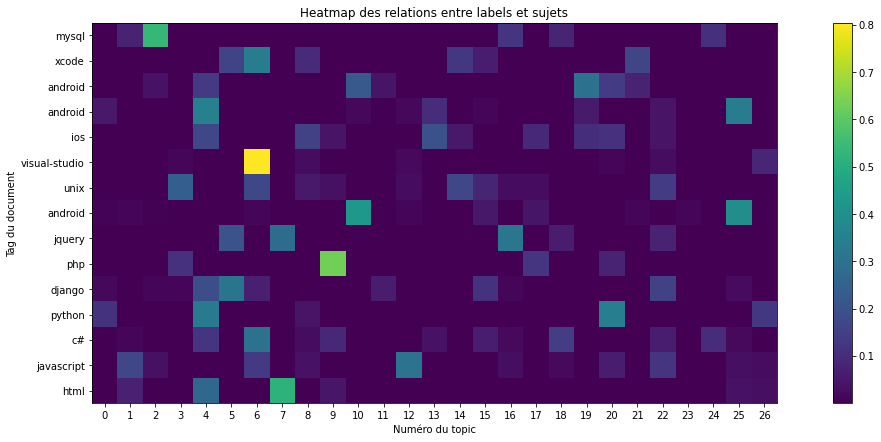

In [42]:
# Relation entre les tags et les sujets
plt.figure(figsize=(20, 7))
plt.imshow(X_train_lda[:15])
plt.xticks(np.arange(n_topics))
plt.xlabel('Numéro du topic')
plt.ylabel('Tag du document')
plt.yticks(np.arange(15), train.loc[:15, 'Label'])
plt.colorbar()
plt.title("Heatmap des relations entre labels et sujets")
plt.savefig("heatmap_tags_topics.png", bbox_inches='tight')

##### Une certaine corrélation peut être faite entre les sujets et les tags. En effet on peut voir par exemple que le sujet 2 semble être relatif à mysql et le sujet 6 à visual-studio par exemple.
Cependant, plusieurs sujets semblent être relatifs au même tags et certains sujets ne semblent représentés par aucun tag (même si la heatmap n'est pas complète).
Cette représentation ne va donc pas être retenue pour la suite de l'étude même si elle semble prometteuse

## C.3. TFIDF + Non Negative Matrix Frequency (NMF)

##### Une autre méthode similaire à la LDA et la représentation par matrice de fréquence non négative. On va utiliser le même nombre de sujets que pour la représentation LDA pour faire une comparaison avec celle-ci

In [43]:
n_topics = scores.index(max(scores))+topics[0]
nmf = NMF(n_components=n_topics,
          alpha=1.,
          l1_ratio=0.5,
          init='nndsvd',
          random_state=0)
X_train_nmf = nmf.fit_transform(X_train_tfidf)
print('La matrice NMF du jeu d\'entrainement représente {} documents par {} sujets'.format(
    X_train_nmf.shape[0], X_train_nmf.shape[1]))
X_test_nmf = nmf.transform(X_test_tfidf)
print('La matrice NMF du jeu de test représente {} documents par {} sujets'.format(
    X_test_nmf.shape[0], X_test_nmf.shape[1]))

La matrice NMF du jeu d'entrainement représente 20805 documents par 27 sujets
La matrice NMF du jeu de test représente 4991 documents par 27 sujets


In [44]:
# Affichage des thèmes
n_top_word = 10
display_topics(nmf, tfidf_feature_names, n_top_word)

Topic 0
look within vim dom properly changed jar pattern method current
Topic 1
file directory folder using path command want error way find
Topic 2
string convert character public return like get way new int
Topic 3
git branch commit repository master remote change push merge commits
Topic 4
android layoutwidth layoutheight wrapcontent textview dp app application studio fillparent
Topic 5
div class px id height element width cs content html
Topic 6
table column sql mysql database query select row server data
Topic 7
array element numpy way var int like php convert loop
Topic 8
difference use two one explain used example method would please
Topic 9
list item element way python like get new two want
Topic 10
look within vim dom properly changed jar pattern method current
Topic 11
look within vim dom properly changed jar pattern method current
Topic 12
python print module import use way function using code script
Topic 13
date format day time datetime month current get new two
Topic 14
l

##### Comme pour la LDA, certains sujets sont interprétables, peut-être même plus facilement que pour la LDA. Cependant encore une fois cela demande une expertise que je n'ai pas. C'est pourquoi je ne retiendrais tout de même pas ce modèle pour la suite

# D. Modélisations

##### On va étudier différents modèles supervisés adapté au problème multiclasse unilabel: 
- Classifier naive de Bayes
- Classifier Ridge
- Arbre de décision
- Forêt aléatoire
- SVC linéaire
- KNN
- Régression logistique

##### On fait au préalable une recherche des meilleurs hyperparamètres des modèles KNN, SVC linéaire et Régression logistique

In [45]:
y_true = test['Label']
y_train = train['Label']

##### La métrique utilisée pour tuner les modèles KNN et Régression logistique est l'aire sous la courbe ROC (AUC)

##### La métrique utilisée pour tuner le modèle de SVC linéaire est le score-f1 car il n'est pas possible de calculer directement l'AUC avec un GridSearchCV combiné avec un SVCLinear

In [46]:
def best_param_model(model, param_name, range_param, X_train, score):
    grid_cv = GridSearchCV(
        model,
        param_grid={param_name: range_param},
        scoring=score
    )
    grid_cv.fit(X_train, y_train)

    # graphique pour recherche best param
    plt.figure(figsize=(10, 5))
    plt.plot(range_param, grid_cv.cv_results_['mean_test_score'])
    plt.xlabel(param_name)
    plt.ylabel('Score moyen')
    plt.title(
        'Score moyen sur le jeu d\'entrainement\nen fonction de {}'.format(param_name))

    return grid_cv.best_params_[param_name]

##### En plus des métriques classiques, on va utiliser le top 3 précision et le top 5 précision qui permettent d'évaluer la précision sur les 3 ou 5 premiers tags (tags avec la probabilité la plus élevée). Comme nous sommes passés de multilabels à unilabels, la précision est diminuée, en effet on essaie de prédire un unique tag alors que plusieurs tags pouvaient être assignés à chaque question. En vérifiant la precision sur plus qu'un tag, on pallie à ce problème.

In [47]:
def top_n_accuracy(y_pred_proba, y_true, n):
    y = LabelEncoder().fit_transform(y_true)
    top_n = np.argsort(y_pred_proba, axis=1)
    idx = y_pred_proba.shape[1] - n - 1
    counter = 0
    for i in range(y_pred_proba.shape[0]):
        if y[i] in top_n[i, idx+1:]:
            counter += 1
    return counter*100. / y_pred_proba.shape[0]

## D.1. TF-IDF + PCA

In [48]:
X_train_tfidf_pca = StandardScaler().fit_transform(X_train_tfidf_pca)
X_test_tfidf_pca = StandardScaler().fit_transform(X_test_tfidf_pca)

Le meilleur modèle SVC linéaire avec une entrée TFIDF+PCA a un paramètre de régularisation C de 0.006866488450042998


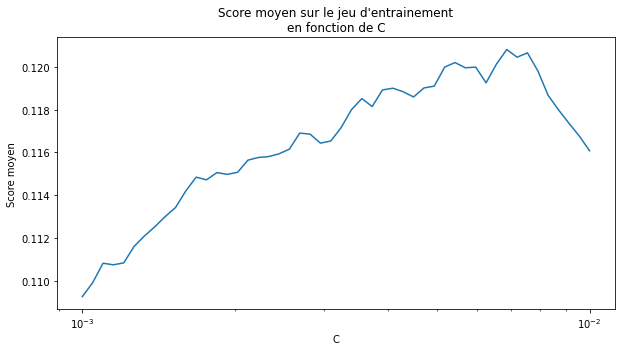

In [49]:
best_linearc_tfidf_pca = best_param_model(LinearSVC(
    random_state=0, tol=30), 'C', np.logspace(-3, -2, 50), X_train_tfidf_pca, 'f1_macro')
plt.xscale('log')
print("Le meilleur modèle SVC linéaire avec une entrée TFIDF+PCA a un paramètre de régularisation C de {}".format(
    best_linearc_tfidf_pca))
plt.savefig('linearsvc_tfidf_pca.png', bbox_inches='tight')

Le meilleur modèle KNN avec une entrée TF-IDF+PCA a 419 voisins


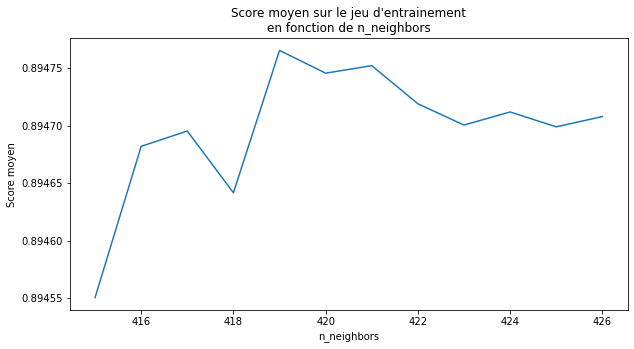

In [50]:
best_k_tfidf_pca = best_param_model(KNeighborsClassifier(
), 'n_neighbors', range(415, 427, 1), X_train_tfidf_pca, 'roc_auc_ovr')
print("Le meilleur modèle KNN avec une entrée TF-IDF+PCA a {} voisins".format(best_k_tfidf_pca))
plt.savefig('knn_tfidf_pca.png', bbox_inches='tight')

Le meilleur modèle de régression logistique avec une entrée TF-IDF+PCA a un paramètre de régularisation C de 0.9236708571873861 


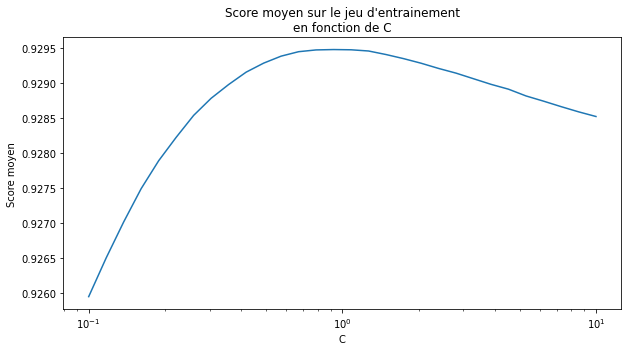

In [19]:
best_c_tfidf_pca = best_param_model(LogisticRegression(
    max_iter=500, penalty='l2'), 'C', np.logspace(-1, 1, 30), X_train_tfidf_pca, 'roc_auc_ovr')
plt.xscale('log')
print("Le meilleur modèle de régression logistique avec une entrée TF-IDF+PCA a un paramètre de régularisation C de {} ".format(best_c_tfidf_pca))
plt.savefig('logisticreg_tfidf_pca.png', bbox_inches='tight')

In [56]:
bilan_table = pd.DataFrame(columns=['Train Time(s)', 'Test Time(s)',
                                    'Accuracy', 'Top 3 Accuracy', 'Top 5 Accuracy', 'AUC', 'F1-score'])

estimators = [
    ('Naive Bayes Classifier', GaussianNB()),
    ('Ridge Classifier', CalibratedClassifierCV(RidgeClassifier())),
    ('Decision Tree', DecisionTreeClassifier(random_state=0)),
    ('Random Forest', RandomForestClassifier(n_estimators=200, random_state=0)),
    ('Linear SVC', CalibratedClassifierCV(
        LinearSVC(C=best_linearc_tfidf_pca, tol=30, random_state=0))),
    ('KNN', KNeighborsClassifier(n_neighbors=best_k_tfidf_pca)),
    ('Logistic Regression', LogisticRegression(
        max_iter=300, C=best_c_tfidf_pca, penalty='l2'))
]

for estimator in estimators:
    start_train = time.time()
    model = estimator[1].fit(X_train_tfidf_pca, y_train)
    end_train = time.time()

    start_test = time.time()
    y_pred = model.predict(X_test_tfidf_pca)
    y_pred_proba = model.predict_proba(X_test_tfidf_pca)
    end_test = time.time()

    # Performances
    accuracy = metrics.accuracy_score(y_true, y_pred)*100
    f1 = metrics.f1_score(y_true, y_pred, average='macro')*100
    auc = metrics.roc_auc_score(
        y_true, y_pred_proba, average='macro', multi_class='ovr')*100
    top_3_accuracy = top_n_accuracy(y_pred_proba, y_true, 3)
    top_5_accuracy = top_n_accuracy(y_pred_proba, y_true, 5)

    # resultat
    bilan_table.loc[estimator[0]] = [float(end_train-start_train), float(
        end_test - start_test), accuracy, top_3_accuracy, top_5_accuracy, auc, f1]

bilan_table.style.format({'Train Time(s)': "{:.2f}", 'Test Time(s)': '{:.2f}', 'Accuracy': '{:.2f}%', 'Top 3 Accuracy': '{:.2f}%', 'Top 5 Accuracy': '{:.2f}%', 'AUC': '{:.2f}%', 'F1-score': '{:.2f}%'})\
    .highlight_max(color='orange', subset=['Train Time(s)', 'Test Time(s)'])\
    .highlight_min(color='green', subset=['Train Time(s)', 'Test Time(s)'])\
    .highlight_max(color='green', subset=['Accuracy', 'Top 3 Accuracy', 'Top 5 Accuracy', 'AUC', 'F1-score'])\
    .highlight_min(color='orange', subset=['Accuracy', 'Top 3 Accuracy', 'Top 5 Accuracy', 'AUC', 'F1-score'])

,Train Time(s),Test Time(s),Accuracy,Top 3 Accuracy,Top 5 Accuracy,AUC,F1-score
Naive Bayes Classifier,1.91,0.64,29.09%,50.33%,59.53%,84.99%,17.62%
Ridge Classifier,6.85,0.23,40.35%,59.91%,68.72%,91.55%,10.52%
Decision Tree,3.03,0.04,30.96%,31.90%,32.24%,56.29%,13.43%
Random Forest,53.12,3.24,46.48%,66.52%,74.59%,88.20%,19.18%
Linear SVC,6.24,0.34,42.10%,60.13%,67.16%,90.40%,12.24%
KNN,0.26,28.70,40.27%,61.21%,70.11%,89.38%,12.39%
Logistic Regression,37.53,0.05,46.46%,67.34%,75.70%,92.93%,20.09%


##### La régression logistique est le modèle avec les meilleures performances lorsque l'on a une entre TFIDF+PCA malgré son temps d'apprentissage plutot conséquent.

## D.2. Doc2Vec

In [51]:
X_train_d2v = StandardScaler().fit_transform(X_train_d2v)
X_test_d2v = StandardScaler().fit_transform(X_test_d2v)

Le meilleur modèle SVC linéaire avec une entrée Doc2Vec a un paramètre de régularisation C de 0.0018420699693267163


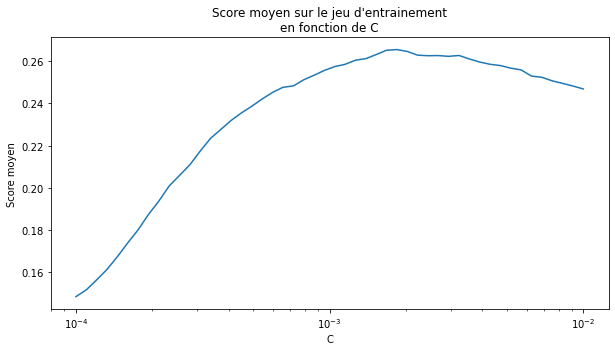

In [52]:
best_linearc_d2v = best_param_model(LinearSVC(
    random_state=0, tol=30), 'C', np.logspace(-4, -2, 50), X_train_d2v, 'f1_macro')
print("Le meilleur modèle SVC linéaire avec une entrée Doc2Vec a un paramètre de régularisation C de {}".format(best_linearc_d2v))
plt.xscale('log')
plt.savefig('linearsvc_d2v.png', bbox_inches='tight')

Le meilleur modèle KNN avec une entrée Doc2Vec a 6430 voisins


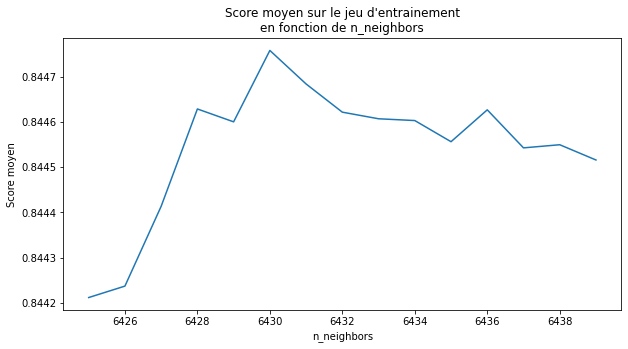

In [61]:
best_k_d2v = best_param_model(
    KNeighborsClassifier(), 'n_neighbors', range(6425, 6440, 1), X_train_d2v, 'roc_auc_ovr')
print("Le meilleur modèle KNN avec une entrée Doc2Vec a {} voisins".format(best_k_d2v))
plt.savefig('knn_d2v.png', bbox_inches='tight')

Le meilleur modèle de régression logistique avec une entrée Doc2Vec a un paramètre de régularisation C de 0.057361525104486784 


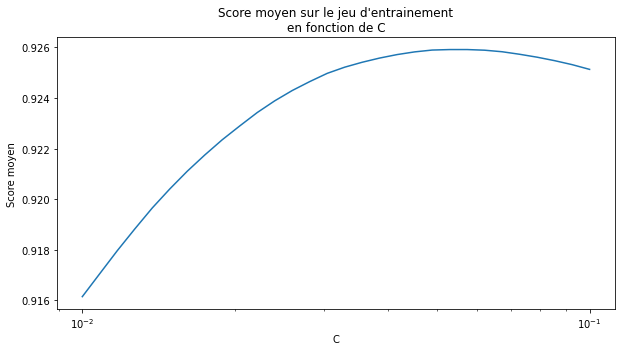

In [53]:
best_c_d2v = best_param_model(LogisticRegression(
    max_iter=300, penalty='l2'), 'C', np.logspace(-2, -1, 30), X_train_d2v, 'roc_auc_ovr')
plt.xscale("log")
print("Le meilleur modèle de régression logistique avec une entrée Doc2Vec a un paramètre de régularisation C de {} ".format(best_c_d2v))
plt.savefig('logisticreg_d2v.png', bbox_inches='tight')

In [62]:
bilan_table = pd.DataFrame(columns=['Train Time(s)', 'Test Time(s)',
                                    'Accuracy', 'Top 3 Accuracy', 'Top 5 Accuracy', 'AUC', 'F1-score'])

estimators = [
    ('Naive Bayes Classifier', GaussianNB()),
    ('Ridge Classifier', CalibratedClassifierCV(RidgeClassifier())),
    ('Decision Tree', DecisionTreeClassifier(random_state=1)),
    ('Random Forest', RandomForestClassifier(n_estimators=200, random_state=1)),
    ('Linear SVC', CalibratedClassifierCV(
        LinearSVC(C=best_linearc_d2v, tol=30, random_state=0))),
    ('KNN', KNeighborsClassifier(n_neighbors=best_k_d2v)),
    ('Logistic Regression', LogisticRegression(
        max_iter=300, C=best_c_d2v, penalty='l2'))
]


for estimator in estimators:
    # Avec doc2vec+pca
    start_train = time.time()
    model = estimator[1].fit(X_train_d2v, y_train)
    end_train = time.time()

    start_test = time.time()
    y_pred = model.predict(X_test_d2v)
    y_pred_proba = model.predict_proba(X_test_d2v)
    end_test = time.time()

    # Performances
    accuracy = metrics.accuracy_score(y_true, y_pred)*100
    f1 = metrics.f1_score(y_true, y_pred, average='macro')*100
    auc = metrics.roc_auc_score(
        y_true, y_pred_proba, average='macro', multi_class='ovr')*100
    top_3_accuracy = top_n_accuracy(y_pred_proba, y_true, 3)
    top_5_accuracy = top_n_accuracy(y_pred_proba, y_true, 5)

    # resultat
    bilan_table.loc[estimator[0]] = [float(end_train-start_train), float(
        end_test - start_test), accuracy, top_3_accuracy, top_5_accuracy, auc, f1]

bilan_table.style.format({'Train Time(s)': "{:.2f}", 'Test Time(s)': '{:.2f}', 'Accuracy': '{:.2f}%', 'Top 3 Accuracy': '{:.2f}%', 'Top 5 Accuracy': '{:.2f}%', 'AUC': '{:.2f}%', 'F1-score': '{:.2f}%'})\
    .highlight_max(color='orange', subset=['Train Time(s)', 'Test Time(s)'])\
    .highlight_min(color='green', subset=['Train Time(s)', 'Test Time(s)'])\
    .highlight_max(color='green', subset=['Accuracy', 'Top 3 Accuracy', 'Top 5 Accuracy', 'AUC', 'F1-score'])\
    .highlight_min(color='orange', subset=['Accuracy', 'Top 3 Accuracy', 'Top 5 Accuracy', 'AUC', 'F1-score'])

,Train Time(s),Test Time(s),Accuracy,Top 3 Accuracy,Top 5 Accuracy,AUC,F1-score
Naive Bayes Classifier,0.14,1.85,24.28%,39.13%,46.32%,74.37%,20.62%
Ridge Classifier,17.85,0.26,47.45%,65.80%,73.11%,90.70%,21.87%
Decision Tree,9.96,0.01,15.23%,16.57%,16.99%,52.16%,5.38%
Random Forest,124.28,2.76,37.43%,54.08%,61.69%,76.51%,11.67%
Linear SVC,12.41,0.33,47.75%,64.60%,71.45%,88.31%,22.13%
KNN,1.01,102.71,12.44%,34.82%,44.48%,83.16%,0.86%
Logistic Regression,99.27,0.02,52.09%,71.57%,78.42%,90.48%,30.98%


##### La régression logistique est le modèle optimal selon les métriques de précision et le F1-score lorsque l'on a une entrée Doc2Vec. Le RidgeClassifier a un score AUC encore meilleur mais au vu des autres métriques, on ne va pas le sélectionner

# E. Modèle optimal

##### Les métriques nous indiquent que le meilleur modèle est :
- un modèle avec représentation TF-IDF
- une réduction dimensionnelle PCA à 23 composantes principales
- une méthode de classification qui est la regression logistique

In [20]:
final_model = make_pipeline(
    TfIdfCustomized(),
    PCA(n_components=n_pca_tfidf),
    StandardScaler(),
    LogisticRegression(max_iter=300, C=best_c_tfidf_pca, penalty='l2'))

final_model.fit(train['Text'], train['Label'])

Pipeline(steps=[('tfidfcustomized', TfIdfCustomized()),
                ('pca', PCA(n_components=23)),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.9236708571873861, max_iter=300))])

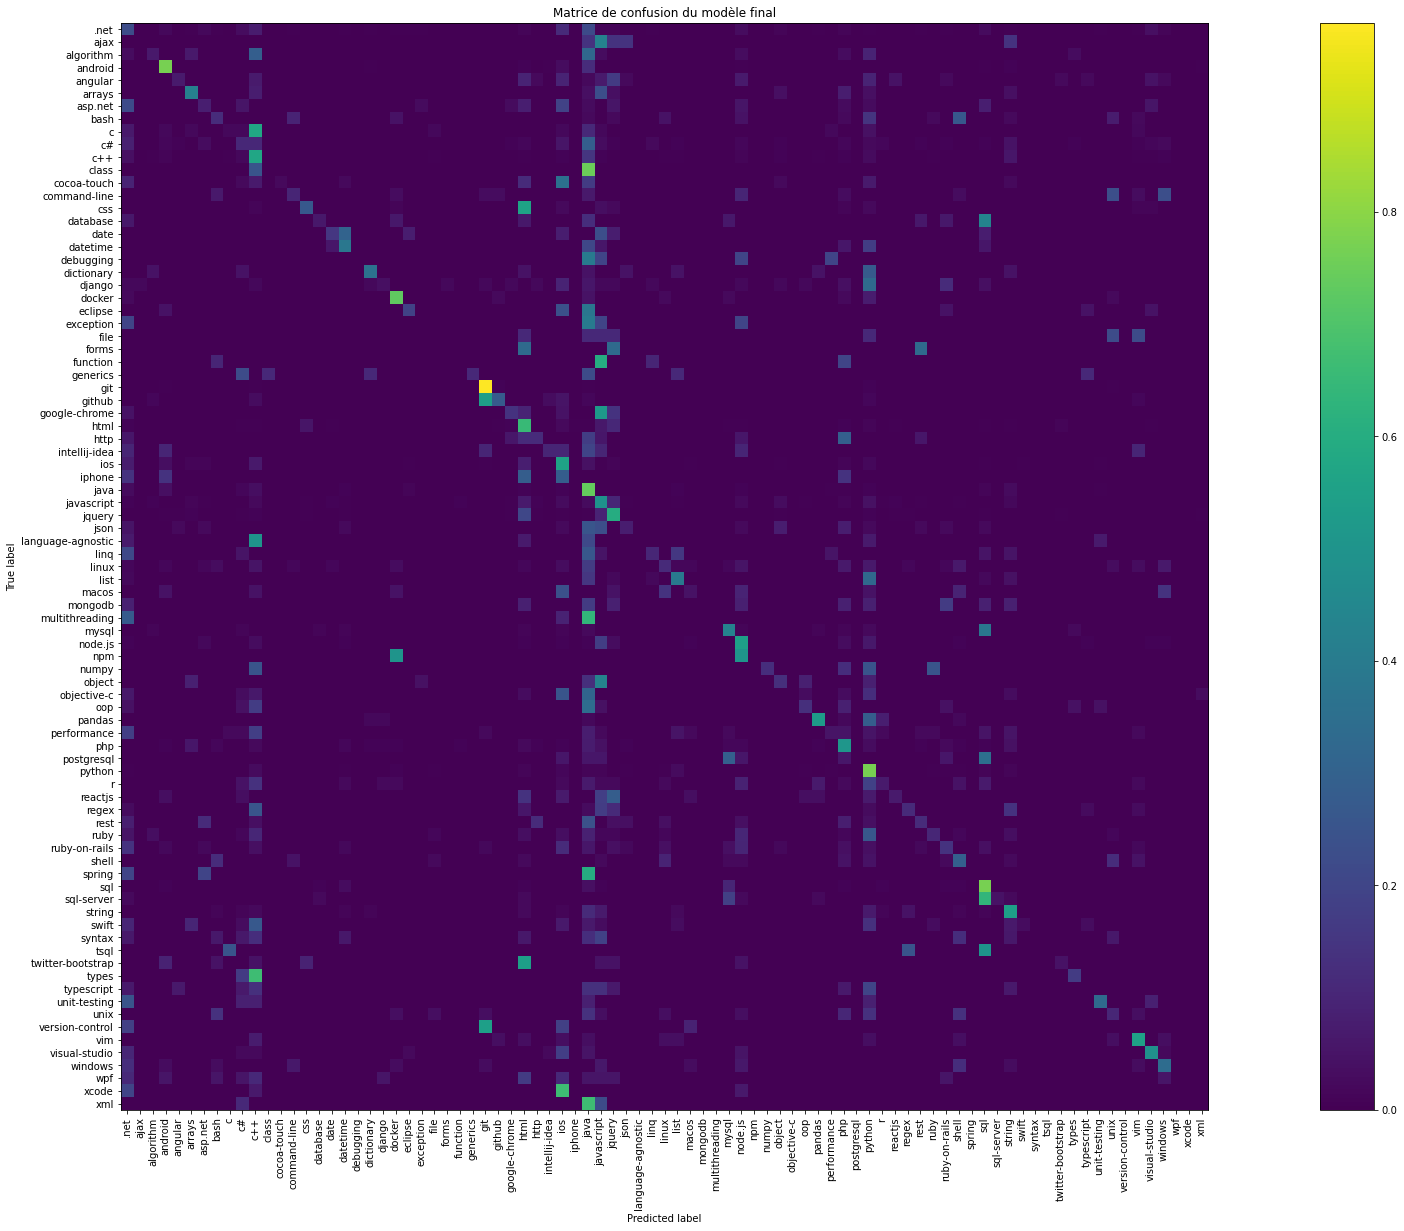

In [21]:
# Matrice de confusion
fig, ax = plt.subplots(figsize=(40, 20))
metrics.plot_confusion_matrix(final_model, test['Text'], test['Label'],
                              normalize='true', ax=ax, xticks_rotation='vertical', include_values=False)
plt.title('Matrice de confusion du modèle final')
plt.savefig('confusion_matrix_final_model.png', bbox_inches='tight')

##### La matrice de confusion nous montre les labels sur lesquels la prédiction est la plus difficile. On voit cependant que lorsqu'il y a des erreurs de classification, généralement la mauvaise classe attribuée à un sujet proche de la classe réelle.
La porosité des classes s'expliquent notamment par les prétraitements effectués sur le texte (lemmatisation, suppression de la ponctuation)

In [22]:
pickle.dump(final_model, open('final_model.sav', 'wb'))